In [1]:
import os
import shutil
import pathlib
import pandas as pd
import re

In [2]:
la_image_metadata = pd.read_csv('../../data_samples/results/whole_set_results/pa_latin_art.csv')
nonla_image_metadata = pd.read_csv('../../data_samples/results/whole_set_results/pa_nonLa_art.csv')

In [3]:
#Still need to download the images that were sampled before we can introduce the directory, file_downloaded, or file_name columns
#Accessioned/Directory can be dropped & Percent_in_NGA added to LA IMAGE metadata

In [4]:
la_image_metadata = la_image_metadata.drop(['accessioned', 'displaydate'], axis = 1)

In [5]:
proportion_ofCountry = la_image_metadata['Country Name'].value_counts(normalize=True)

In [6]:
la_image_metadata['percent_fromCountry'] = la_image_metadata['Country Name'].apply(lambda x: proportion_ofCountry[x])

In [7]:
la_image_metadata = la_image_metadata.rename({'Percent_in_NGA': 'percent_fromArtist'}, axis=1)

In [8]:
proportion_ofArtist = nonla_image_metadata.forwarddisplayname.value_counts(normalize=True)
nonla_image_metadata['percent_fromArtist'] = nonla_image_metadata.forwarddisplayname.apply(lambda x: proportion_ofArtist[x])

In [9]:
print(la_image_metadata.shape)
print(nonla_image_metadata.shape)

(354, 38)
(197584, 35)


In [10]:
#the following columns are missing in the NON LA IMAGE dataset and need to be added (after sampling taken place)
set(la_image_metadata.columns) - set(nonla_image_metadata.columns)

{'directory', 'file_downloaded', 'file_name'}

In [11]:
la_image_directory = '../../la_images'

In [12]:
la_image_metadata['directory'] = [la_image_directory] * len(la_image_metadata)

In [13]:
la_image_metadata['image_fp'] = la_image_metadata['directory'] + '/' + la_image_metadata['file_name']

### Splitting the La Art which already has directory and image reference data
Still have to download the images for the non-LA art and add directory and image reference data

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(la_image_metadata, la_image_metadata.title, train_size=0.8,test_size=0.2, random_state=101)

### Splitting the Non La Art, for sampling, which does not have directory and image reference data

In [15]:
from sklearn.model_selection import train_test_split
#1580 rows for training (0.008%) & 396 (0.002%) for validation/testing == 1976 for one iteration of sample (1/100 of total dataset)
X_train_sample, X_valid_sample, y_train_sample, y_valid_sample = train_test_split(nonla_image_metadata, nonla_image_metadata.title, train_size=0.008,test_size=0.002, random_state=626)

In [33]:
X_valid_sample

,objectid,title,medium,dimensions,inscription,markings,attributioninverted,attribution,provenancetext,creditline,...,forwarddisplayname,lastname,nationality,constituenttype,expanded_url,percent_fromCountry,Country Name,Country,Continent,percent_fromArtist
181864,206907.0,La Hollande Cintre du Salon de la Paix en face...,engraving on laid paper,sheet: 64 × 90.2 cm (25 3/16 × 35 1/2 in.)\npl...,In plate: LL: Peint par Ch. Le Brun et dessiné...,NaN,"Massé, Jean-Baptiste (designer) and Louis Desp...",Jean-Baptiste Massé (designer) and Louis Despl...,Dyson Perrins Museum Trust (stamp). R.W. Burns...,Gift of David H. McDonnell,...,Charles Le Brun,Le Brun,French,individual,https://api.nga.gov/iiif/466dd719-9d6c-4371-b2...,0.101900,France,FR,Europe,0.000152
10978,6736.0,The Flagellation,woodcut,NaN,NaN,NaN,"Dürer, Albrecht",Albrecht Dürer,NaN,Rosenwald Collection,...,Lessing Julius Rosenwald,Rosenwald,American,individual,https://api.nga.gov/iiif/6a36a204-6ab0-41ae-af...,0.709936,United States,US,North America,0.261980
163394,51333.0,Philip II of Spain on His Throne,etching,NaN,NaN,NaN,"Tempesta, Antonio",Antonio Tempesta,NaN,R.L. Baumfeld Collection,...,Antonio Tempesta,Tempesta,Italian,individual,https://api.nga.gov/iiif/b0115a46-b98b-4775-98...,0.045247,Italy,IT,Europe,0.000304
66548,169413.0,September Morn,pen and black ink over graphite on wove paper,sheet: 34.29 × 36.2 cm (13 1/2 × 14 1/4 in.),lower right in black ink: C.K.Berryman / THE E...,NaN,"Berryman, Clifford Kennedy",Clifford Kennedy Berryman,"the artist, Washington, DC; Corcoran Gallery o...",Corcoran Collection (Gift of the artist),...,Clifford Kennedy Berryman,Berryman,American,individual,https://api.nga.gov/iiif/2966eaae-4bf3-4413-9a...,0.709936,United States,US,North America,0.000192
121102,170228.0,Untitled,paper relief,sheet: 25.72 × 36.83 cm (10 1/8 × 14 1/2 in.),lower right verso in graphite: Goldberg '74,NaN,"Goldberg, Michael",Michael Goldberg,"The Honorable William H.G. FitzGerald, Mr. Des...",Corcoran Collection (Gift of William H. G. Fit...,...,Michael Goldberg,Goldberg,American,individual,https://api.nga.gov/iiif/22e9679c-98c4-47dd-81...,0.709936,United States,US,North America,0.000051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88188,152008.0,Cicada,color lithograph on Georges Duchêne Calcaire h...,image: 67.31 × 51.75 cm (26 1/2 × 20 3/8 in.)\...,lower left in graphite: Trial Proof; lower rig...,embossed lower right: © [Gemini G.E.L.]; stamp...,"Johns, Jasper",Jasper Johns,"the artist, Sharon, Connecticut; acquired 2010...",Patrons' Permanent Fund and Special Friends of...,...,Richard Garst,Garst,American,individual,https://api.nga.gov/iiif/55e4aec6-185b-4489-8f...,0.709936,United States,US,North America,0.000344
112997,8694.0,The Triumph of Julius Caesar [no.5 and 6 plus ...,chiaroscuro woodcut,NaN,NaN,NaN,"Andreani, Andrea after Andrea Mantegna",Andrea Andreani after Andrea Mantegna,NaN,Rosenwald Collection,...,Lessing Julius Rosenwald,Rosenwald,American,individual,https://api.nga.gov/iiif/cc3af392-be24-4995-8c...,0.709936,United States,US,North America,0.261980
194548,37038.0,Two Mercenaries and a Woman,woodcut,NaN,NaN,NaN,"Graf I, Urs",Urs Graf I,NaN,Rosenwald Collection,...,Urs Graf I,Graf I,Swiss,individual,https://api.nga.gov/iiif/cd90cff0-859d-47ca-8b...,0.003839,Switzerland,CH,Europe,0.000040
44937,142723.0,Target with Plaster Casts [3rd state],etching and aquatint in black on wove paper,sheet: 75.88 × 56.04 cm (29 7/8 × 22 1/16 in.)...,"lower right, in graphite: J Johns '79 - '80; l...",NaN,"Johns, Jasper",Jasper Johns,"the artist, Sharon, Connecticut; acquired 2008...",Patrons' Permanent Fund and Special Friends of...,...,Jasper Johns,Johns,American,individual,https://api.nga.gov/iiif/970c679a-0bbf-4d17-a0...,0.709936,United States,US,North America,0.023722


### Making the individual directories for testing and training
For both Latin American and Non-LA art

In [17]:
test_directory = '/test'
train_directory = '/train'

In [18]:
parent_image_folder = '../../latinamerican-2-imagefolder-split'

test_fp = [parent_image_folder + test_directory] * len(X_valid)
train_fp = [parent_image_folder + train_directory] * len(X_train)

In [19]:
X_valid['destination_fp'] = test_fp
X_train['destination_fp'] = train_fp

In [20]:
def move_images(valid, train):
    #moves images into folders from the datasets' image_fp and into their destination_fp
    def shuttle(index):
        try:
            shutil.move(index['image_fp'], index['destination_fp'])
        except:
            pass

    valid.apply(lambda x: shuttle(x), axis = 1)
    train.apply(lambda x: shuttle(x), axis = 1)

In [21]:
move_images(X_valid, X_train)

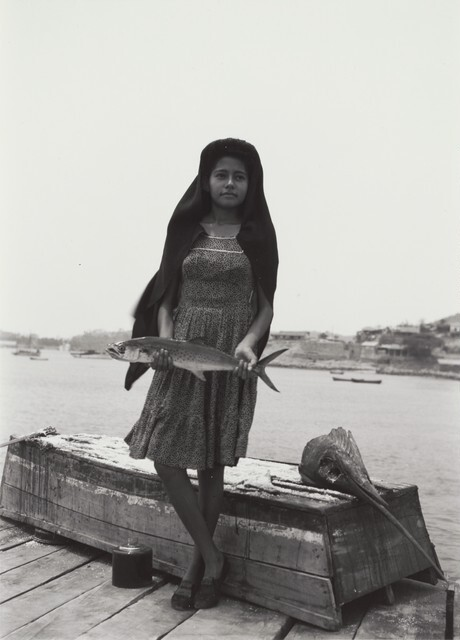

In [22]:
from IPython.display import Image
Image(filename='../../la_Images/"...Un_Pez_que_Llaman_Sierra"_("...A_Fish_Called_Saw")_Álvarez_Bravo.jpg')

### Checking the status of the image directories post-move
Latin America Only

In [23]:
import os.path
from os import path

In [24]:
#checks the presence of file at destination filepath
def update_file_presence(dataset):
    dataset['file_downloaded'] = dataset['destination_fp'].apply(path.exists)
    return dataset

In [25]:
X_valid = update_file_presence(X_valid)
X_train = update_file_presence(X_train)

In [26]:
print(X_valid.file_downloaded.sum() / len(X_valid))
print(X_train.file_downloaded.sum() / len(X_train))
print('All Images Moved Successfully')

1.0
1.0
All Images Moved Successfully


In [27]:
def incur_fp_column(dataset):
    #need to check strength of previous move
    dataset = dataset.drop('image_fp', axis = 1)
    dataset.rename(columns={'destination_fp': 'image_fp'}, inplace = True)
    return dataset

In [28]:
X_train = incur_fp_column(X_train)
X_valid = incur_fp_column(X_valid)

In [29]:
def incur_directory_column(dataset):
    directory = [parent_image_folder] * len(dataset)
    dataset['directory'] = directory

    subfolder = [re.search('test|train', x).group() for x in dataset.image_fp]
    dataset['subfolder'] = subfolder

In [30]:
incur_directory_column(X_valid)
incur_directory_column(X_train)